# Interpretable Explanations of Black Boxes by Meaningful Perturbation
https://arxiv.org/abs/1704.03296, ICCV '17

In [18]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from torchvision import models
import cv2
from tqdm import tqdm

In [19]:
use_cuda = torch.cuda.is_available()

In [20]:
# parameter
learning_rate = 0.1
max_iterations = 1000
l1_coeff = 0.01
tv_coeff = 0.1
tv_beta = 3

# target image
img_path = './dog_cat.jpg'
# img_path = ''

In [21]:
# total var
def total_var_norm(img, tv_beta):
    img = img[0, 0, :]
    row_grad = torch.mean(torch.abs((img[:-1, :] - img[1:, :])).pow(tv_beta))
    col_grad = torch.mean(torch.abs((img[:, :-1] - img[:, 1:])).pow(tv_beta))
    return row_grad + col_grad

In [22]:
# Imagenet Preprocess
def preprocess(img):
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    preprocessed_img = img.copy()[:, :, ::-1]
    for i in range(3):
        preprocessed_img[:, :, i] -= means[i]
        preprocessed_img[:, :, i] /= stds[i]
        
    preprocessed_img = np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))

    if use_cuda:
        preprocessed_img_tensor = torch.from_numpy(preprocessed_img).cuda()
    else:
        preprocessed_img_tensor = torch.from_numpy(preprocessed_img)

    preprocessed_img_tensor.unsqueeze_(0)
    img_tensor = Variable(preprocessed_img_tensor, requires_grad=False)
    return img_tensor

In [23]:
def numpy_to_torch(img, requires_grad=True):
    # mask
    if len(img.shape) < 3:
        output = np.float32([img])
    else:
        # image
        output = np.transpose(img, (2, 0, 1))
    output = torch.from_numpy(output)
    
    if use_cuda:
        output = output.cuda()

    output.unsqueeze_(0)
    img_tensor = Variable(output, requires_grad=requires_grad)
    return img_tensor

In [24]:
# load model
model = models.vgg19(pretrained=True)
model.eval()
if use_cuda:
    model.cuda()

# not train model
for p in model.features.parameters():
    p.requires_grad = False
for p in model.classifier.parameters():
    p.requires_grad = False

In [30]:
img_path

'./dog_cat.jpg'

In [32]:
# load img
original_img = cv2.imread(img_path, 1)
#print(original_img)

In [33]:
original_img = cv2.resize(original_img, (224, 224))
img = np.float32(original_img) / 255

# blur img
blurred_img1 = cv2.GaussianBlur(img, (9, 9), 5)
blurred_img2 = np.float32(cv2.medianBlur(original_img, 9)) / 255
blurred_img_numpy = (blurred_img1 + blurred_img2) / 2

# mask
mask_init = np.ones((28, 28), dtype=np.float32)

In [34]:
# To torch tensor
img = preprocess(img)
blurred_img = preprocess(blurred_img2)
mask = numpy_to_torch(mask_init)

if use_cuda:
    upsample = torch.nn.UpsamplingBilinear2d(size=(224, 224)).cuda()
else:
    upsample = torch.nn.UpsamplingBilinear2d(size=(224, 224))

In [35]:
# optimizer
optimizer = torch.optim.Adam([mask], lr=learning_rate)

target = torch.nn.Softmax()(model(img))

# inference target image category
category = np.argmax(target.cpu().data.numpy())

/home/jake/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


In [36]:
category

185

In [37]:
for i in tqdm(range(max_iterations)):
    
    # mask upsampling
    upsampled_mask = upsample(mask)

    # expand demension
    upsampled_mask = upsampled_mask.expand(1, 3, upsampled_mask.size(2), upsampled_mask.size(3))

    # masking
    perturbated_input = img.mul(upsampled_mask) + blurred_img.mul(1 - upsampled_mask)

    # make noise
    noise = np.zeros((224, 224, 3), dtype=np.float32)
    cv2.randn(noise, 0, 0.4)
    noise = numpy_to_torch(noise)
    
    # add noise
    perturbated_input = perturbated_input + noise
    
    # perturbated image output
    outputs = torch.nn.Softmax()(model(perturbated_input))
    
    # mask loss
    loss = l1_coeff * torch.mean(torch.abs(1 - mask)) + tv_coeff * total_var_norm(mask, tv_beta) + outputs[0, category]

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # clamping
    mask.data.clamp_(0, 1)

100%|██████████| 1000/1000 [00:10<00:00, 92.56it/s]


In [38]:
np.shape(perturbated_input)

torch.Size([1, 3, 224, 224])

In [39]:
# mask, img, blurred

tmp_m = upsampled_mask.cpu().data.numpy()[0]
tmp_m = np.transpose(tmp_m, (1, 2, 0))

tmp_m = (tmp_m - np.min(tmp_m)) / np.max(tmp_m)
tmp_m = 1 - tmp_m
heatmap = cv2.applyColorMap(np.uint8(255 * tmp_m), cv2.COLORMAP_JET)

heatmap = np.float32(heatmap) / 255
cam = heatmap + np.float32(original_img) / 255
cam /= np.max(cam)


In [40]:
np.shape(heatmap)

(224, 224, 3)

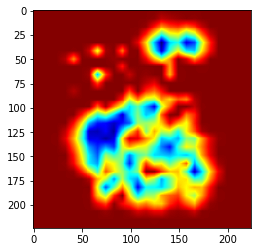

In [41]:
plt.imshow(heatmap)

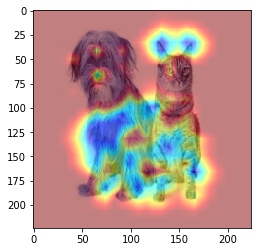

In [42]:
plt.imshow(cam)

# ROAR / KAR
mask 성능을 정량적으로 평가
https://arxiv.org/abs/1806.10758 , NeurIPS 2019


In [18]:
# mask에서 정렬후 일부분씩 지워가면서 성능에 대한 AUC를 내면됨